In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
import os
os.chdir('../')
from STEM.model import *
from STEM.utils import *
os.chdir('./revise/')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.settings.figdir='reivse_figure'

In [3]:
scdata = pd.read_csv('../data/mousedata_2020/E1z2/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('../data/mousedata_2020/E1z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('../data/mousedata_2020/E1z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('../data/mousedata_2020/E1z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('../data/mousedata_2020/E1z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

In [4]:
sc.pp.calculate_qc_metrics(adata,percent_top=None, log1p=False, inplace=True)
adata.obs['n_genes_by_counts'].median()

sc.pp.calculate_qc_metrics(stadata,percent_top=None, log1p=False, inplace=True)
stadata.obs['n_genes_by_counts'].median()

dp = 1- adata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()
dp

0.5836734693877551

In [5]:
class setting( object ):
    pass
seed_all(2022)
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', 'log_revise/Mouse_E1z2')
setattr(opt, 'n_genes', 351)
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 3)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)
setattr(opt, 'mmdbatch', 1000)
setattr(opt, 'dp', dp)

In [6]:
%%time
testmodel = SOmodel(opt)
testmodel.togpu()
# loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())

CPU times: user 758 ms, sys: 639 ms, total: 1.4 s
Wall time: 5.94 s


In [7]:
testmodel.model_path = '../log/Mouse_E1z2/model.pth'

In [8]:
testmodel.load()

===> Loading model from ../log/Mouse_E1z2/model.pth
<=== Success!


In [9]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()

In [10]:
def all_coord(mappingmtx,spcoor):
    mappingnorm = mappingmtx.div(mappingmtx.sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

def k_coord(mappingmtx,spcoor, k=1):
    maskmap = np.zeros_like(mappingmtx)

    argmask = np.argsort(1/mappingmtx.values,axis=1)

    for i in range(argmask.shape[0]):
        for j in range(k):
            maskmap[i,argmask[i,j]]=1

    mappingnorm = (maskmap*mappingmtx).div((maskmap*mappingmtx).sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

In [11]:
adata.obsm['spatialDA'] = all_coord(pd.DataFrame(netsc2st,index=adata.obs_names,columns=stadata.obs_names),spcoor)

# Saliency Map

In [12]:
sc.settings.figdir = './revise_figure/'

## Spinalcoord

In [13]:
spinalcoorddata = scdata[(scmetadata['celltype_mapped_refined']=='Spinal cord')&(scmetadata.y_global>1410)].copy()
spinalcoorddata = torch.Tensor(spinalcoorddata.values).cuda()

spinalmetadata = scmetadata[scmetadata['celltype_mapped_refined']=='Spinal cord']
spinalmetadata = spinalmetadata[spinalmetadata.y_global>1410]

spinaladata = adata[(scmetadata['celltype_mapped_refined']=='Spinal cord')&(scmetadata.y_global>1410),:].copy()

In [14]:
def curve_length(x,y):
    x = np.linspace(0, y-x, 100)
    curve = a5*x**5+a4*x**4 + a3*x**3 + a2*x**2 +a1*x+a0
    return np.sum(np.sqrt(np.sum((curve[:-1] - curve[1:])**2,axis=1)))

In [15]:
spinalspcoor =  spinaladata.obsm['spatial']

a5,a4, a3,a2,a1,a0= np.polyfit(spinalspcoor[:,0],spinalspcoor[:,1],5)
fity = a5*spinalspcoor[:,0]**5+a4*spinalspcoor[:,0]**4 + a3*spinalspcoor[:,0]**3 + a2*spinalspcoor[:,0]**2 +a1*spinalspcoor[:,0]+a0

pseudotime = []
for i in range(spinalspcoor.shape[0]):
    pseudotime.append(curve_length(spinalspcoor[0,:],spinalspcoor[i,:]))

pseudotime = np.array(pseudotime)/1e8
pseudotime = (pseudotime.max() - pseudotime)/(pseudotime.max()-pseudotime.min())
spinaladata.obs['pseudotime'] = pseudotime
spinaladata.obsm['pseudotime'] = np.expand_dims(np.array(pseudotime),1)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'embryo' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future ver

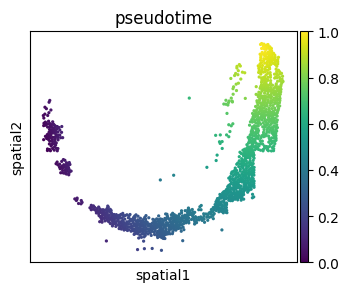

In [16]:
figsize(4,3)
sc.pl.spatial(spinaladata,color='pseudotime',spot_size=2,basis='spatial')

In [17]:
sc.pp.neighbors(spinaladata,use_rep='pseudotime')
sc.tl.leiden(spinaladata,resolution=0.1)

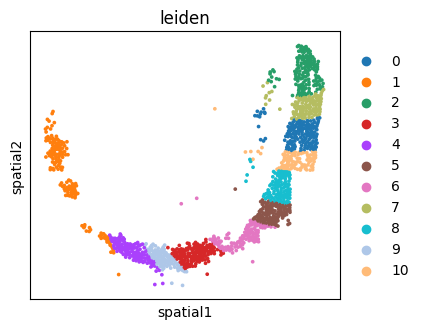

In [18]:
figsize(4,5)
sc.pl.spatial(spinaladata,color='leiden',spot_size=2)

In [19]:
class Captummodel(nn.Module):
    def __init__(self, netE, stembedding):
        super(Captummodel, self).__init__()

        self.netE = netE
        self.netE.eval()
        self.stembedding = stembedding.t()

    def forward(self, x):
        x = self.netE(x)
        return x.mm(self.stembedding)
from captum.attr import IntegratedGradients

In [20]:
from tqdm import tqdm
capt = Captummodel(testmodel.netE,stembedding.detach())
capt.eval()


allsali = []
allbestidx = []
alldelta = []
allscemb = []
for i in tqdm(range(spinalcoorddata.shape[0])):
    inputdata = spinalcoorddata[i].unsqueeze(0)
    scembedding = testmodel.netE(inputdata)
    allscemb.append(scembedding.detach().cpu().numpy())
    spinal2st = scembedding.mm(stembedding.detach().t())
    idx = spinal2st.argmax()
    ig = IntegratedGradients(capt)
    attributions,delta = ig.attribute(inputdata,target=idx,return_convergence_delta=True)
    allsali.append(attributions.detach().cpu().numpy()[0])
    alldelta.append(delta.mean().item())
allsali = np.array(allsali)

100%|██████████| 1416/1416 [00:12<00:00, 115.18it/s]


In [21]:
saliadata = sc.AnnData(pd.DataFrame(allsali,columns=scdata.columns,index = spinaladata.obs_names),obs = spinaladata.obs)
saliadata.obsm['spatial'] = spinaladata.obsm['spatial']
saliadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']

In [22]:
sc.tl.rank_genes_groups(saliadata,groupby='leiden',method='wilcoxon')

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

In [23]:
sc.get.rank_genes_groups_df(saliadata,group=None,pval_cutoff=0.05,log2fc_min=0).names.unique().shape

(272,)

In [28]:
sdgdf = sc.get.rank_genes_groups_df(saliadata,pval_cutoff =0.05,log2fc_min=0,group=None)

#### DEG

In [29]:
sc.tl.rank_genes_groups(spinaladata,groupby='leiden',method='wilcoxon')

In [30]:
degdf = sc.get.rank_genes_groups_df(spinaladata,pval_cutoff =0.05,log2fc_min=0,group=None)

In [31]:
len(set(sdgdf.names.tolist())),len(set(degdf.names.tolist()))

(272, 218)

In [32]:
list(set(degdf.names.tolist()).difference(set(sdgdf.names.tolist())))

['Lyl1',
 'Gpc4',
 'Eomes',
 'Sox17',
 'Ovol2',
 'Tbx5',
 'Cdh5',
 'Popdc2',
 'Hoxa9',
 'Ahnak',
 'Col26a1',
 'Bambi',
 'Sp5',
 'Jarid2',
 'Col4a1',
 'Dlk1',
 'Mrap',
 'Sox10',
 'Krt18',
 'Furin',
 'Setd1b',
 'Hoxd4',
 'Foxa1',
 'Gmpr']

In [33]:
degdffull = sc.get.rank_genes_groups_df(spinaladata,group=None)
sdgdffull = sc.get.rank_genes_groups_df(saliadata,group=None)

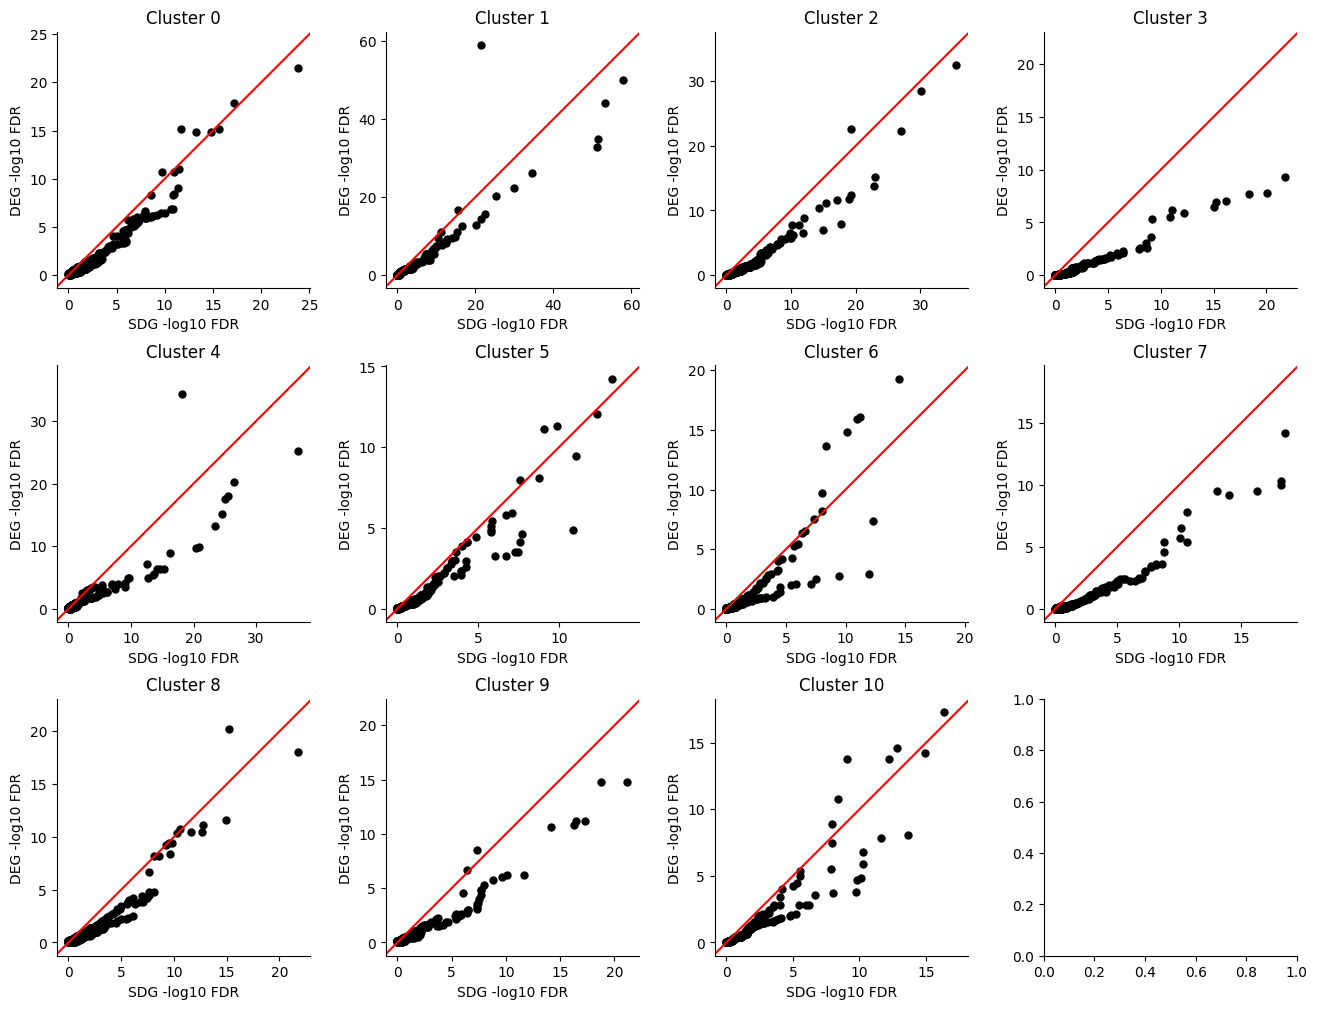

In [42]:
from matplotlib_venn import venn2
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for g in range(11):
    subdeg = degdffull[degdffull.group==str(g)]
    subsdg = sdgdffull[sdgdffull.group==str(g)]
    sdgcommon = list(set(subsdg.names.tolist()).intersection(set(subdeg.names.tolist())))
    tmpax = axes[g//4][g%4]
    p1 = -np.log10(subsdg.loc[subsdg.names.isin(sdgcommon),'pvals_adj'])
    p2 = -np.log10(subdeg.loc[subdeg.names.isin(sdgcommon),'pvals_adj'])
    tmpax.scatter(p1,p2,s=25,c='black')
    # tmpax.set_yscale('log')
    # tmpax.set_xscale('log')
    tmpax.title.set_text(f'Cluster {g}')
    tmpax.axis('equal')
    lim1,lim2=min(tmpax.get_ylim()[0],tmpax.get_xlim()[0]),max(tmpax.get_ylim()[1],tmpax.get_xlim()[1])
    # lim2=1
    tmpax.plot([lim1,lim2],[lim1,lim2],color='red')
    x_ticks = tmpax.get_xticks()
    tmpax.set_yticks(x_ticks)
    tmpax.set_xlim(lim1,lim2)
    tmpax.set_ylim(lim1,lim2)
    tmpax.set_xlabel('SDG -log10 FDR')
    tmpax.set_ylabel('DEG -log10 FDR')
# plt.savefig('revise_figure/deg-sdg-pvalue.pdf',bbox_inches='tight')

In [43]:
sdgunique = list(set(sdgdf.names.tolist()).difference(set(degdf.names.tolist())))
degunique = list(set(degdf.names.tolist()).difference(set(sdgdf.names.tolist())))
sdgcommon = list(set(sdgdf.names.tolist()).intersection(set(degdf.names.tolist())))

In [44]:
len(sdgunique),len(sdgcommon),len(degunique)

(78, 194, 24)

In [47]:
import colorbm as cbm
import seaborn as sns
sns.set_palette(sns.color_palette(cbm.pal('npg').as_hex))
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [48]:
sdguniquedf = sdgdf.loc[sdgdf.names.isin(sdgunique),:].sort_values('pvals_adj')
sdguniquegene = sdguniquedf.names[:15].unique().tolist()

attriscore = saliadata[:,sdguniquegene].X
genescore = spinaladata[:,sdguniquegene].X

highregion = []
for sg in sdguniquegene:
    highregion.append(sdgdf.loc[sdgdf.names==sg,:].sort_values('pvals_adj').iloc[0,0])

timerange={}
for i in range(10):
    tmp = saliadata.obs.loc[saliadata.obs.leiden==str(i),'pseudotime']
    timerange[str(i)] = (tmp.min(),tmp.max())

In [50]:
sdguniquegene

['Cers4',
 'Gng3',
 'Pdgfa',
 'Smarcd3',
 'Myb',
 'Lefty1',
 'Foxa2',
 'Slc7a3',
 'Per2',
 'Dppa2']

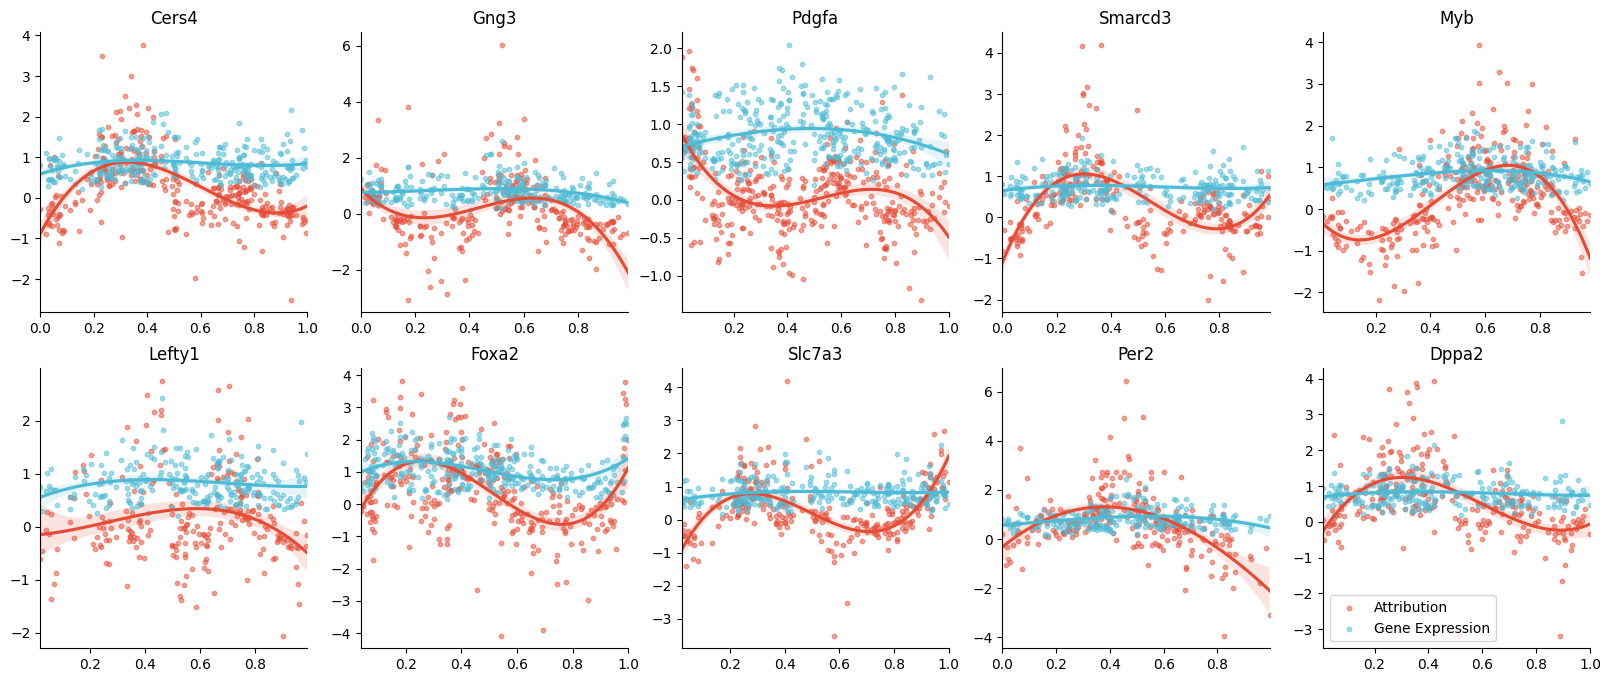

In [53]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    mask= np.abs(attriscore[:,i])>0.01
    sns.regplot(x=saliadata.obs['pseudotime'][mask],y=attriscore[:,i][mask],order=3,seed=42,scatter_kws={'s': 10,'alpha':0.5},ax=axes[i//5][i%5],label='Attribution')    
    sns.regplot(x=spinaladata.obs['pseudotime'][mask],y=genescore[:,i][mask],order=3,seed=42,scatter_kws={'s': 10,'alpha':0.5},ax=axes[i//5][i%5],label='Gene Expression')
    axes[i//5][i%5].set_xlabel('')
    axes[i//5][i%5].set_title(sdguniquegene[i])
plt.legend()
# plt.savefig('revise_figure/deg-line.pdf',bbox_inches='tight')

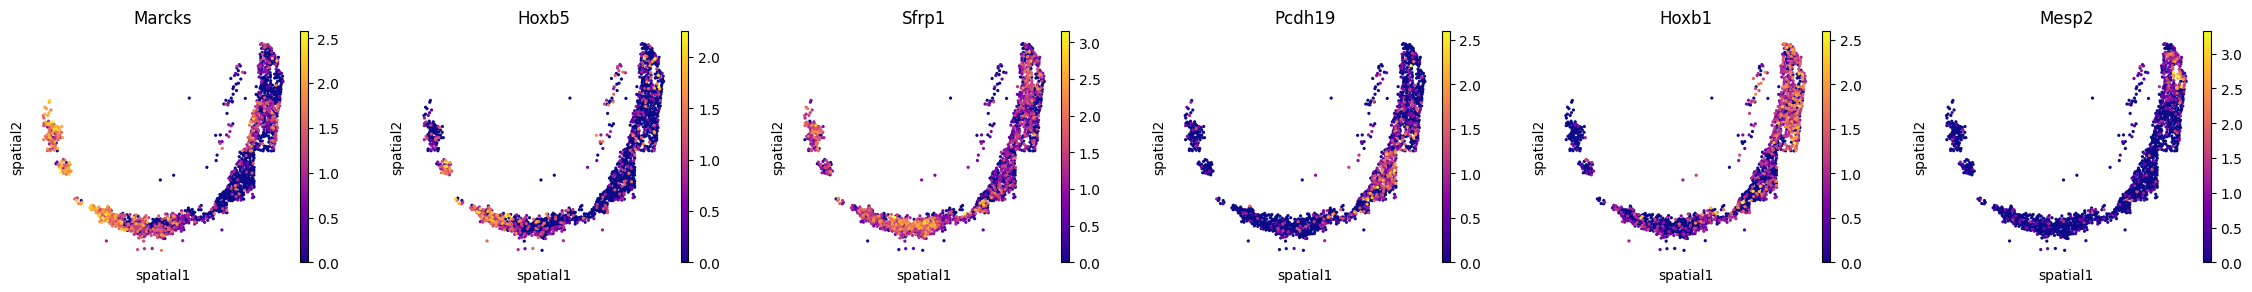

In [58]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
figsize(3.8,3)
sc.pl.spatial(spinaladata,spot_size=2,color=['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2'],cmap='plasma',ncols=6,basis='spatial',save='trajectory_exrpession.pdf')

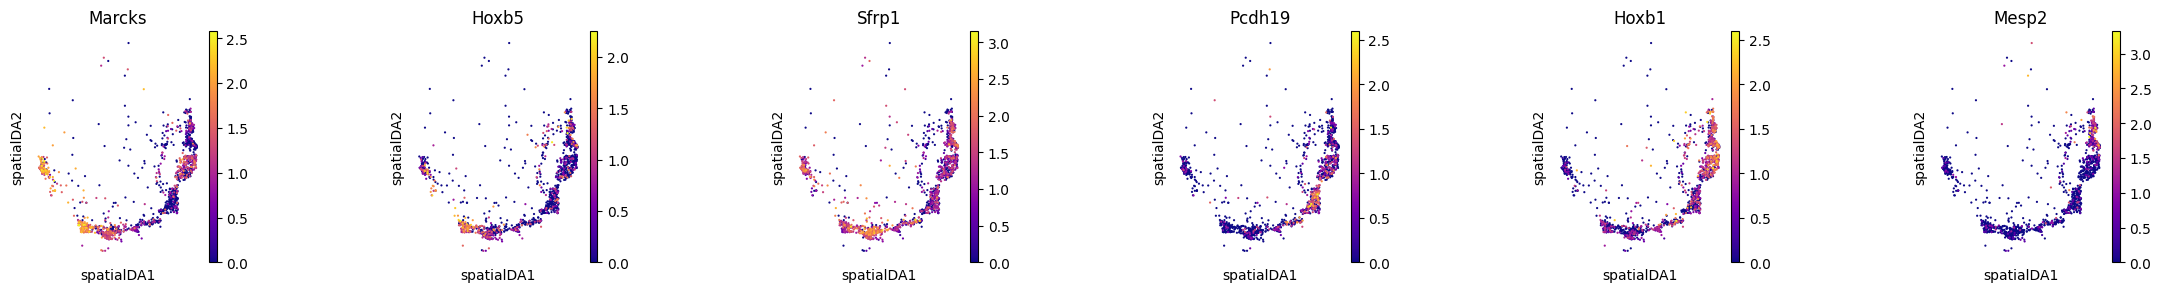

In [59]:
sc.pl.spatial(spinaladata,spot_size=2,color=['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2'],cmap='plasma',ncols=6,basis='spatialDA',save='trajectory_exrpession_reconstructed.pdf')

In [60]:
pseudotime = []
for i in range(spinalspcoor.shape[0]):
    pseudotime.append(curve_length(spinaladata.obsm['spatialDA'][0,:],spinaladata.obsm['spatialDA'][i,:]))
    
pseudotime = np.array(pseudotime)/1e8
pseudotime = (pseudotime.max() - pseudotime)/(pseudotime.max()-pseudotime.min())
spinaladata.obs['pseudotime_reconstructed'] = pseudotime
spinaladata.obsm['pseudotime_reconstructed'] = np.expand_dims(np.array(pseudotime),1)

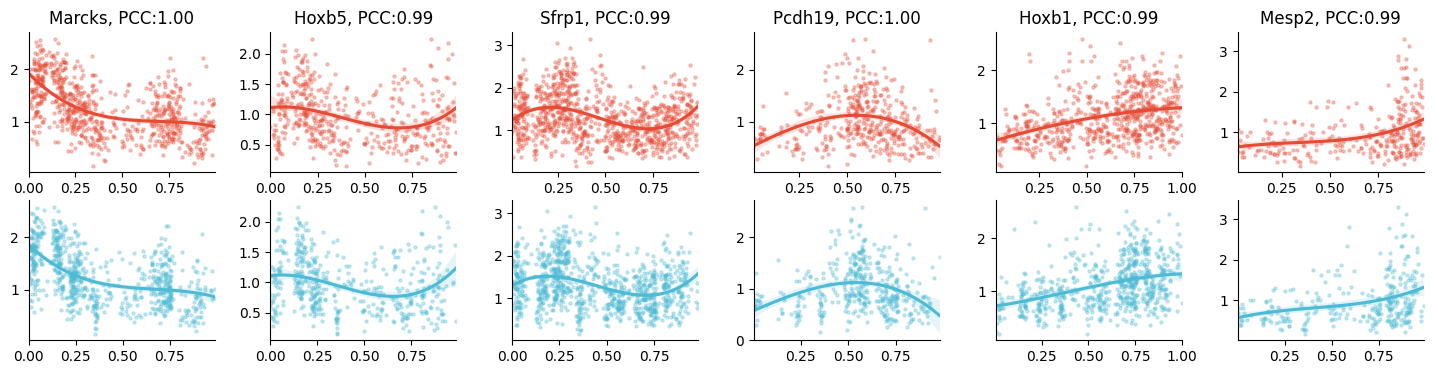

In [75]:
rcParams['axes.spines.left'] = True
rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(2, 6, figsize=(18, 4))
fig.subplots_adjust(wspace=0.3)
candig = ['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2']
for i in range(6):
    genename = candig[i]
    exp = spinaladata[:,genename].X.toarray()[:,0]
    mask= np.abs(exp)>0.01
    regplot = sns.regplot(x=spinaladata.obs['pseudotime_reconstructed'][mask],y=exp[mask],order=3,seed=42,scatter_kws={'s': 5,'alpha':0.3},ax=axes[1][i],label='Reconstructed',color=cbm.pal('npg').as_hex[1])    
    geregplot =sns.regplot(x=spinaladata.obs['pseudotime'][mask],y=exp[mask],order=3,seed=42,scatter_kws={'s': 5,'alpha':0.3},ax=axes[0][i],label='Raw')

    x1 = spinaladata.obs['pseudotime_reconstructed'][mask]
    x2 = spinaladata.obs['pseudotime'][mask]
    y1 = exp[mask]
    y2 = exp[mask]

    coefficients1 = np.polyfit(x1, y1, 3)
    coefficients2 = np.polyfit(x2, y2, 3)
    poly1 = np.poly1d(coefficients1)
    poly2 = np.poly1d(coefficients2)

    x1 = np.sort(x1.values)
    x2 = np.sort(x2.values)

    correlation_coefficient, _ = scipy.stats.pearsonr(poly1(x1), poly2(x2))
    
    axes[0][i].set_xlabel('')
    axes[0][i].set_title(f'{genename}, PCC:{correlation_coefficient:.2f}')
    axes[1][i].set_xlabel('')
plt.savefig('revise_figure/markergenepearson.pdf',bbox_inches='tight')